In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb

import warnings
import os
import pickle

from datetime import date, datetime

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score,\
    roc_auc_score, f1_score, roc_curve, log_loss

from sklearn.model_selection import train_test_split, StratifiedKFold,\
    GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import catboost as cb
import catboost.utils as cbu
from catboost.utils import get_gpu_device_count

import xgboost as xgb
import lightgbm as lgb

import optuna

import hyperopt
from hyperopt import tpe

In [ ]:
import plotly.io as pio
pio.renderers.default='notebook'

In [ ]:
sb.set(rc={'figure.figsize':(8.5, 6.0)})

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/uplift-shift-23/baseline.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/train_purch/train_purch.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/products.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/clients2.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/train.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/test.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/test_purch/test_purch.csv


In [ ]:
path_client = '/kaggle/input/uplift-shift-23/x5-uplift-valid/data/clients2.csv'
path_products = '/kaggle/input/uplift-shift-23/x5-uplift-valid/data/products.csv'
path_test = '/kaggle/input/uplift-shift-23/x5-uplift-valid/data/test.csv'
path_train = '/kaggle/input/uplift-shift-23/x5-uplift-valid/data/train.csv'

path_train_purch = '/kaggle/input/uplift-shift-23/x5-uplift-valid/train_purch/train_purch.csv'
path_test_purch = '/kaggle/input/uplift-shift-23/x5-uplift-valid/test_purch/test_purch.csv'
path_baseline = '/kaggle/input/uplift-shift-23/baseline.csv'

## Load date

In [ ]:
df_client = pd.read_csv(path_client)
df_products = pd.read_csv(path_products)
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

df_train_purch = pd.read_csv(path_train_purch)
df_test_purch = pd.read_csv(path_test_purch)
df_baseline = pd.read_csv(path_baseline)

In [ ]:
df_train['target'] = np.int16(df_train['treatment_flg'] == df_train['purchased'])

In [ ]:
df_client.head()

,client_id,client_id.1,first_issue_date,first_redeem_date,age,gender
0,000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [ ]:
df_products.head()

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
1,0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
2,0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
4,0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


In [ ]:
df_train.head()

,client_id,treatment_flg,purchased,target
0,ad6561e2d8,1,1,1
1,7c1ccbf93f,1,1,1
2,b58fadcab6,1,1,1
3,e99e6fabb9,0,0,1
4,27fb6f8520,1,1,1


In [ ]:
df_train_purch.info()
df_train_purch.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15998952 entries, 0 to 15998951
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   client_id                object 
 1   transaction_id           object 
 2   transaction_datetime     object 
 3   regular_points_received  float64
 4   express_points_received  float64
 5   regular_points_spent     float64
 6   express_points_spent     float64
 7   purchase_sum             float64
 8   store_id                 object 
 9   product_id               object 
 10  product_quantity         float64
 11  trn_sum_from_iss         float64
 12  trn_sum_from_red         float64
dtypes: float64(8), object(5)
memory usage: 1.5+ GB


,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


## Data processing

Client age

In [ ]:
first_quant, three_quant = np.percentile(df_client.age, [25, 75])
interval_quant = three_quant - first_quant
max_value = three_quant + interval_quant * 1.5
min_value = first_quant - interval_quant * 1.5
df_client.loc[(df_client.age > max_value) | (df_client.age < min_value), 'age'] = df_client.age.median()# np.nan
# median_age = df_client.age.median()
# df_client['age'] = df_client['age'].fillna(median_age)

In [ ]:
# df_client.loc[(df_client.age > 100) | (df_client.age < 14), 'age'] = df_client.age.median()

In [ ]:
df_client['first_issue_date'] = pd.to_datetime(df_client.first_issue_date, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_client['first_redeem_date'] = pd.to_datetime(df_client.first_redeem_date, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_train_purch['transaction_datetime'] = pd.to_datetime(df_train_purch.transaction_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_test_purch['transaction_datetime'] = pd.to_datetime(df_test_purch.transaction_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')

Client first_redeem_date

In [ ]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          200039 non-null  object        
 1   client_id.1        0 non-null       float64       
 2   first_issue_date   200039 non-null  datetime64[ns]
 3   first_redeem_date  182493 non-null  datetime64[ns]
 4   age                200039 non-null  int64         
 5   gender             200039 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 9.2+ MB


In [ ]:
df_client.first_redeem_date.fillna(df_client.first_redeem_date.median(), inplace=True)

The merging client dateframe with train/test set

In [ ]:
df_train = df_client.drop(['client_id.1'], axis=1).merge(df_train.drop(['treatment_flg', 'purchased'], axis=1))
df_train.head()

,client_id,first_issue_date,first_redeem_date,age,gender,target
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,0
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1
2,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,1
3,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,1
4,000220a0a7,2017-12-09 17:26:20,2018-10-04 14:59:29,45,M,0


In [ ]:
df_test = df_client.drop(['client_id.1'], axis=1).merge(df_test)
df_test.head()

,client_id,first_issue_date,first_redeem_date,age,gender
0,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
1,00035a21d9,2019-02-09 14:46:22,2019-03-02 15:18:35,69,U
2,00038f9200,2018-12-07 14:03:50,2019-01-12 13:57:20,79,U
3,0004315e57,2018-11-25 16:20:56,2019-02-02 15:02:43,38,U
4,0006fca4bf,2019-02-20 10:47:30,2018-06-06 17:15:02,57,U


Processing customer purchases

In [ ]:
df_train_purch.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


First and last transaction

In [ ]:
train_client_transaction = df_train_purch.groupby('client_id')\
    .agg(first_transaction=('transaction_datetime', 'min'), last_transaction=('transaction_datetime', 'max')).reset_index()
df_train = train_client_transaction.merge(df_train)

In [ ]:
test_client_transaction = df_test_purch.groupby('client_id')\
    .agg(first_transaction=('transaction_datetime', 'min'), last_transaction=('transaction_datetime', 'max')).reset_index()
df_test = test_client_transaction.merge(df_test)

Mean and sum for points, purchase by clients

In [ ]:
train_transaction = df_train_purch.groupby(['client_id', 'transaction_id'])[['regular_points_received',
                                                         'express_points_received',
                                                         'regular_points_spent',
                                                         'express_points_spent',
                                                         'purchase_sum']].mean().reset_index()
train_transaction.head()

,client_id,transaction_id,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum
0,000012768d,6a0e96d0bc,8.0,0.0,0.0,0.0,803.0
1,000012768d,7e3e2e3984,10.0,0.0,0.0,0.0,1007.0
2,000012768d,b34f23306e,2.0,0.0,0.0,0.0,419.0
3,000012768d,c1ca85d462,5.7,0.0,0.0,0.0,574.0
4,000036f903,0a3d640bf4,7.0,0.0,0.0,0.0,700.0


In [ ]:
df_train = train_transaction.groupby('client_id').agg(mean_regular_points_received=('regular_points_received', 'mean'),
                                                    std_regular_points_received=('regular_points_received', 'std'),
                                                      median_regular_points_received=('regular_points_received', 'median'),
                                                      sum_regular_points_received=('regular_points_received', 'sum'),
                                                      mean_express_points_received=('express_points_received', 'mean'),
                                                    std_express_points_received=('express_points_received', 'std'),
                                                      median_express_points_received=('express_points_received', 'median'),
                                                      sum_express_points_received=('express_points_received', 'sum'),
                                                      mean_regular_points_spent=('regular_points_spent', 'mean'),
                                                    std_regular_points_spent=('regular_points_spent', 'std'),
                                                      median_regular_points_spent=('regular_points_spent', 'median'),
                                                      sum_regular_points_spent=('regular_points_spent', 'sum'),
                                                      mean_express_points_spent=('express_points_spent', 'mean'),
                                                    std_express_points_spent=('express_points_spent', 'std'),
                                                      median_express_points_spent=('express_points_spent', 'median'),
                                                      sum_express_points_spent=('express_points_spent', 'sum'),
                                                      mean_purchase_sum=('purchase_sum', 'mean'),
                                                    std_purchase_sum=('purchase_sum', 'std'),
                                                      median_purchase_sum=('purchase_sum', 'median'),
                                                      sum_purchase_sum=('purchase_sum', 'sum'))\
                                                        .reset_index().merge(df_train)
df_train.head()

,client_id,mean_regular_points_received,std_regular_points_received,median_regular_points_received,sum_regular_points_received,mean_express_points_received,std_express_points_received,median_express_points_received,sum_express_points_received,mean_regular_points_spent,...,std_purchase_sum,median_purchase_sum,sum_purchase_sum,first_transaction,last_transaction,first_issue_date,first_redeem_date,age,gender,target
0,000012768d,6.425000,3.433536,6.85,25.7,0.000,0.000000,0.0,0.0,0.000000,...,258.000484,688.500,2803.00,2018-12-01 07:12:45,2019-03-14 15:01:47,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,0
1,000036f903,1.715625,1.484785,1.30,54.9,1.875,10.606602,0.0,60.0,0.000000,...,161.780987,267.000,9805.00,2018-11-28 10:48:36,2019-03-17 10:29:37,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1
2,0001f552b0,5.260000,10.026308,1.60,78.9,0.000,0.000000,0.0,0.0,0.000000,...,295.885838,335.370,6155.18,2018-11-24 07:14:43,2019-03-16 10:54:02,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,1
3,00020e7b18,15.894444,13.460639,14.60,286.1,0.000,0.000000,0.0,0.0,-32.888889,...,1008.952394,1222.675,25819.61,2018-11-23 08:21:26,2019-03-15 12:04:23,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,1
4,000220a0a7,6.940000,11.654233,2.20,104.1,0.000,0.000000,0.0,0.0,0.000000,...,415.204051,451.150,8606.57,2018-12-11 16:54:16,2019-03-12 16:44:43,2017-12-09 17:26:20,2018-10-04 14:59:29,45,M,0


In [ ]:
test_transaction = df_test_purch.groupby(['client_id', 'transaction_id'])[['regular_points_received',
                                                         'express_points_received',
                                                         'regular_points_spent',
                                                         'express_points_spent',
                                                         'purchase_sum']].mean().reset_index()
test_transaction.head()

,client_id,transaction_id,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum
0,00010925a5,081dc6d998,2.3,0.0,0.0,0.0,478.0
1,00010925a5,09af961a1c,2.3,0.0,0.0,0.0,463.0
2,00010925a5,144898073a,1.4,0.0,0.0,0.0,299.0
3,00010925a5,1721d9d308,1.2,0.0,0.0,0.0,250.0
4,00010925a5,1c4bd83e38,5.8,0.0,0.0,0.0,581.0


In [ ]:
df_test = test_transaction.groupby('client_id').agg(mean_regular_points_received=('regular_points_received', 'mean'),
                                                    std_regular_points_received=('regular_points_received', 'std'),
                                                      median_regular_points_received=('regular_points_received', 'median'),
                                                      sum_regular_points_received=('regular_points_received', 'sum'),
                                                      mean_express_points_received=('express_points_received', 'mean'),
                                                    std_express_points_received=('express_points_received', 'std'),
                                                      median_express_points_received=('express_points_received', 'median'),
                                                      sum_express_points_received=('express_points_received', 'sum'),
                                                      mean_regular_points_spent=('regular_points_spent', 'mean'),
                                                    std_regular_points_spent=('regular_points_spent', 'std'),
                                                      median_regular_points_spent=('regular_points_spent', 'median'),
                                                      sum_regular_points_spent=('regular_points_spent', 'sum'),
                                                      mean_express_points_spent=('express_points_spent', 'mean'),
                                                    std_express_points_spent=('express_points_spent', 'std'),
                                                      median_express_points_spent=('express_points_spent', 'median'),
                                                      sum_express_points_spent=('express_points_spent', 'sum'),
                                                      mean_purchase_sum=('purchase_sum', 'mean'),
                                                    std_purchase_sum=('purchase_sum', 'std'),
                                                      median_purchase_sum=('purchase_sum', 'median'),
                                                      sum_purchase_sum=('purchase_sum', 'sum'))\
                                                        .reset_index().merge(df_test)
df_test.head()

,client_id,mean_regular_points_received,std_regular_points_received,median_regular_points_received,sum_regular_points_received,mean_express_points_received,std_express_points_received,median_express_points_received,sum_express_points_received,mean_regular_points_spent,...,mean_purchase_sum,std_purchase_sum,median_purchase_sum,sum_purchase_sum,first_transaction,last_transaction,first_issue_date,first_redeem_date,age,gender
0,00010925a5,1.766667,1.172729,1.45,31.8,0.0,0.0,0.0,0.0,-0.944444,...,326.833333,139.562868,301.00,5883.00,2018-11-25 10:56:18,2019-03-08 07:09:50,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
1,00035a21d9,7.866667,6.803920,7.60,23.6,0.0,0.0,0.0,0.0,-2.666667,...,597.313333,309.604933,765.94,1791.94,2019-02-09 11:46:22,2019-03-02 12:18:35,2019-02-09 14:46:22,2019-03-02 15:18:35,69,U
2,00038f9200,1.725000,2.676811,0.80,82.8,0.0,0.0,0.0,0.0,-0.604167,...,174.687500,130.658912,133.50,8385.00,2018-12-07 11:03:50,2019-03-18 12:48:40,2018-12-07 14:03:50,2019-01-12 13:57:20,79,U
3,0004315e57,4.842857,3.594593,5.30,67.8,0.0,0.0,0.0,0.0,-2.785714,...,542.142857,305.867205,534.00,7590.00,2018-11-25 13:20:56,2019-03-08 11:33:37,2018-11-25 16:20:56,2019-02-02 15:02:43,38,U
4,0006fca4bf,11.800000,19.574473,0.80,35.4,0.0,0.0,0.0,0.0,0.000000,...,713.666667,1054.836638,161.00,2141.00,2019-02-20 07:47:30,2019-03-10 06:56:52,2019-02-20 10:47:30,2018-06-06 17:15:02,57,U


Product count

In [ ]:
train_porduct_stat = df_train_purch[['client_id', 'product_id']]\
    .merge(df_products[['product_id', 'netto', 'is_own_trademark', 'is_alcohol']])\
    .groupby('client_id').agg(mean_netto=('netto', 'mean'),
                              sum_netto=('netto', 'sum'),
                              count_own_trademark=('is_own_trademark', 'sum'),
                              count_alcohol=('is_alcohol', 'sum')).reset_index()
train_porduct_stat.head()

,client_id,mean_netto,sum_netto,count_own_trademark,count_alcohol
0,000012768d,0.540231,28.092,4,0
1,000036f903,0.481877,78.064,14,1
2,0001f552b0,0.483849,41.611,10,0
3,00020e7b18,0.482176,131.152,44,0
4,000220a0a7,0.357918,30.423,16,1


In [ ]:
df_train = train_porduct_stat.merge(df_train)
df_train.head()

,client_id,mean_netto,sum_netto,count_own_trademark,count_alcohol,mean_regular_points_received,std_regular_points_received,median_regular_points_received,sum_regular_points_received,mean_express_points_received,...,std_purchase_sum,median_purchase_sum,sum_purchase_sum,first_transaction,last_transaction,first_issue_date,first_redeem_date,age,gender,target
0,000012768d,0.540231,28.092,4,0,6.425000,3.433536,6.85,25.7,0.000,...,258.000484,688.500,2803.00,2018-12-01 07:12:45,2019-03-14 15:01:47,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,0
1,000036f903,0.481877,78.064,14,1,1.715625,1.484785,1.30,54.9,1.875,...,161.780987,267.000,9805.00,2018-11-28 10:48:36,2019-03-17 10:29:37,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1
2,0001f552b0,0.483849,41.611,10,0,5.260000,10.026308,1.60,78.9,0.000,...,295.885838,335.370,6155.18,2018-11-24 07:14:43,2019-03-16 10:54:02,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,1
3,00020e7b18,0.482176,131.152,44,0,15.894444,13.460639,14.60,286.1,0.000,...,1008.952394,1222.675,25819.61,2018-11-23 08:21:26,2019-03-15 12:04:23,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,1
4,000220a0a7,0.357918,30.423,16,1,6.940000,11.654233,2.20,104.1,0.000,...,415.204051,451.150,8606.57,2018-12-11 16:54:16,2019-03-12 16:44:43,2017-12-09 17:26:20,2018-10-04 14:59:29,45,M,0


In [ ]:
test_porduct_stat = df_test_purch[['client_id', 'product_id']]\
    .merge(df_products[['product_id', 'netto', 'is_own_trademark', 'is_alcohol']])\
    .groupby('client_id').agg(mean_netto=('netto', 'mean'),
                              sum_netto=('netto', 'sum'),
                              count_own_trademark=('is_own_trademark', 'sum'),
                              count_alcohol=('is_alcohol', 'sum')).reset_index()
test_porduct_stat.head()

,client_id,mean_netto,sum_netto,count_own_trademark,count_alcohol
0,00010925a5,0.615551,48.013,9,1
1,00035a21d9,0.419346,10.903,1,0
2,00038f9200,0.546804,86.395,14,0
3,0004315e57,0.366172,44.673,22,0
4,0006fca4bf,0.445714,12.480,4,1


In [ ]:
df_test = test_porduct_stat.merge(df_test)
df_test.head()

,client_id,mean_netto,sum_netto,count_own_trademark,count_alcohol,mean_regular_points_received,std_regular_points_received,median_regular_points_received,sum_regular_points_received,mean_express_points_received,...,mean_purchase_sum,std_purchase_sum,median_purchase_sum,sum_purchase_sum,first_transaction,last_transaction,first_issue_date,first_redeem_date,age,gender
0,00010925a5,0.615551,48.013,9,1,1.766667,1.172729,1.45,31.8,0.0,...,326.833333,139.562868,301.00,5883.00,2018-11-25 10:56:18,2019-03-08 07:09:50,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
1,00035a21d9,0.419346,10.903,1,0,7.866667,6.803920,7.60,23.6,0.0,...,597.313333,309.604933,765.94,1791.94,2019-02-09 11:46:22,2019-03-02 12:18:35,2019-02-09 14:46:22,2019-03-02 15:18:35,69,U
2,00038f9200,0.546804,86.395,14,0,1.725000,2.676811,0.80,82.8,0.0,...,174.687500,130.658912,133.50,8385.00,2018-12-07 11:03:50,2019-03-18 12:48:40,2018-12-07 14:03:50,2019-01-12 13:57:20,79,U
3,0004315e57,0.366172,44.673,22,0,4.842857,3.594593,5.30,67.8,0.0,...,542.142857,305.867205,534.00,7590.00,2018-11-25 13:20:56,2019-03-08 11:33:37,2018-11-25 16:20:56,2019-02-02 15:02:43,38,U
4,0006fca4bf,0.445714,12.480,4,1,11.800000,19.574473,0.80,35.4,0.0,...,713.666667,1054.836638,161.00,2141.00,2019-02-20 07:47:30,2019-03-10 06:56:52,2019-02-20 10:47:30,2018-06-06 17:15:02,57,U


In [ ]:
# day_of_week_dict = {0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 4: 'friday', 5: 'saturday', 6: 'sunday'}

In [ ]:
# train_transaction_date = df_train_purch[['client_id', 'transaction_datetime']].drop_duplicates()
# train_transaction_date['day_of_week'] = pd.to_datetime(train_transaction_date.transaction_datetime,\
#                                                        format='%Y-%m-%d %H:%M:%S').dt.dayofweek


# train_transaction_date.day_of_week = train_transaction_date.day_of_week.map(day_of_week_dict)
# df_train = train_transaction_date.pivot_table(index='client_id',
#                                               columns='day_of_week',
#                                               values='transaction_datetime',
#                                               aggfunc='count', fill_value=0).reset_index().merge(df_train)
# df_train.head()

In [ ]:
# test_transaction_date = df_test_purch[['client_id', 'transaction_datetime']].drop_duplicates()
# test_transaction_date['day_of_week'] = pd.to_datetime(test_transaction_date.transaction_datetime,\
#                                                        format='%Y-%m-%d %H:%M:%S').dt.dayofweek


# test_transaction_date.day_of_week = test_transaction_date.day_of_week.map(day_of_week_dict)
# df_test = test_transaction_date.pivot_table(index='client_id',
#                                               columns='day_of_week',
#                                               values='transaction_datetime',
#                                               aggfunc='count', fill_value=0).reset_index().merge(df_test)
# df_test.head()

Fill NaN

In [ ]:
# df_train.first_redeem_date.fillna(df_train.last_transaction.max(), inplace=True)

Day interval

In [ ]:
def day_interval(x):
    if x < 7:
        return 'night'
    elif x > 17:
        return 'evening'
    elif x >= 7 and x < 13:
        return 'morning'
    else:
        return 'afternoon'

In [ ]:
train_transaction_date = df_train_purch[['client_id', 'transaction_datetime']].drop_duplicates()
train_transaction_date['hour'] = pd.to_datetime(train_transaction_date.transaction_datetime,\
                                                       format='%Y-%m-%d %H:%M:%S').dt.hour

train_transaction_date.hour = train_transaction_date.hour.apply(day_interval)
df_train = train_transaction_date.pivot_table(index='client_id',
                                              columns='hour',
                                              values='transaction_datetime',
                                              aggfunc='count', fill_value=0).reset_index().merge(df_train)

In [ ]:
df_train.head()

,client_id,afternoon,evening,morning,night,mean_netto,sum_netto,count_own_trademark,count_alcohol,mean_regular_points_received,...,std_purchase_sum,median_purchase_sum,sum_purchase_sum,first_transaction,last_transaction,first_issue_date,first_redeem_date,age,gender,target
0,000012768d,1,0,3,0,0.540231,28.092,4,0,6.425000,...,258.000484,688.500,2803.00,2018-12-01 07:12:45,2019-03-14 15:01:47,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,0
1,000036f903,0,0,32,0,0.481877,78.064,14,1,1.715625,...,161.780987,267.000,9805.00,2018-11-28 10:48:36,2019-03-17 10:29:37,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1
2,0001f552b0,7,0,8,0,0.483849,41.611,10,0,5.260000,...,295.885838,335.370,6155.18,2018-11-24 07:14:43,2019-03-16 10:54:02,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,1
3,00020e7b18,1,0,16,1,0.482176,131.152,44,0,15.894444,...,1008.952394,1222.675,25819.61,2018-11-23 08:21:26,2019-03-15 12:04:23,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,1
4,000220a0a7,12,0,2,1,0.357918,30.423,16,1,6.940000,...,415.204051,451.150,8606.57,2018-12-11 16:54:16,2019-03-12 16:44:43,2017-12-09 17:26:20,2018-10-04 14:59:29,45,M,0


In [ ]:
test_transaction_date = df_test_purch[['client_id', 'transaction_datetime']].drop_duplicates()
test_transaction_date['hour'] = pd.to_datetime(test_transaction_date.transaction_datetime,\
                                                       format='%Y-%m-%d %H:%M:%S').dt.hour

test_transaction_date.hour = test_transaction_date.hour.apply(day_interval)
df_test = test_transaction_date.pivot_table(index='client_id',
                                              columns='hour',
                                              values='transaction_datetime',
                                              aggfunc='count', fill_value=0).reset_index().merge(df_test)

In [ ]:
df_test.head()

,client_id,afternoon,evening,morning,night,mean_netto,sum_netto,count_own_trademark,count_alcohol,mean_regular_points_received,...,mean_purchase_sum,std_purchase_sum,median_purchase_sum,sum_purchase_sum,first_transaction,last_transaction,first_issue_date,first_redeem_date,age,gender
0,00010925a5,0,0,17,1,0.615551,48.013,9,1,1.766667,...,326.833333,139.562868,301.00,5883.00,2018-11-25 10:56:18,2019-03-08 07:09:50,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
1,00035a21d9,0,0,3,0,0.419346,10.903,1,0,7.866667,...,597.313333,309.604933,765.94,1791.94,2019-02-09 11:46:22,2019-03-02 12:18:35,2019-02-09 14:46:22,2019-03-02 15:18:35,69,U
2,00038f9200,3,0,44,1,0.546804,86.395,14,0,1.725000,...,174.687500,130.658912,133.50,8385.00,2018-12-07 11:03:50,2019-03-18 12:48:40,2018-12-07 14:03:50,2019-01-12 13:57:20,79,U
3,0004315e57,8,0,4,2,0.366172,44.673,22,0,4.842857,...,542.142857,305.867205,534.00,7590.00,2018-11-25 13:20:56,2019-03-08 11:33:37,2018-11-25 16:20:56,2019-02-02 15:02:43,38,U
4,0006fca4bf,0,0,2,1,0.445714,12.480,4,1,11.800000,...,713.666667,1054.836638,161.00,2141.00,2019-02-20 07:47:30,2019-03-10 06:56:52,2019-02-20 10:47:30,2018-06-06 17:15:02,57,U


Statistic values

Popular product

In [ ]:
df_train_purch.groupby('product_id')['transaction_id'].count().reset_index().sort_values('transaction_id')

,product_id,transaction_id
37085,ef666694f8,1
23260,967f1d4671,1
2705,1150cd593e,1
20114,81e57b54e2,1
28081,b60fa48499,1
...,...,...
12083,4dcf79043e,129695
9710,3e038662c0,134126
29437,bf07df54e1,144643
3407,15ccaa8685,219727


Popular levels product

In [ ]:
df_copy = df_train_purch[['client_id', 'transaction_id', 'transaction_datetime', 'product_id']].merge(df_products).sort_values('transaction_datetime')
df_copy.head()

,client_id,transaction_id,transaction_datetime,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
7713175,27df8bc8bb,6e64997d36,2018-11-21 21:02:33,260db99c88,e344ab2e71,703f4b6eb0,8b5cca6319,bf375b7a11,119.0,eb856243c2,d6c656575f,0.140,0,0
12879615,27df8bc8bb,6e64997d36,2018-11-21 21:02:33,0bf1e1fa3b,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,8ab704a7bf,4981f3a494,0.450,0,0
11674997,27df8bc8bb,6e64997d36,2018-11-21 21:02:33,f6d299b094,e344ab2e71,ed2ad1797c,bd7a98e9af,c0a825c891,313.0,fdde33576a,63243765ed,0.016,0,0
13544345,27df8bc8bb,6e64997d36,2018-11-21 21:02:33,191fc477af,e344ab2e71,ed2ad1797c,bd7a98e9af,c0a825c891,313.0,fdde33576a,63243765ed,0.016,0,0
3066941,27df8bc8bb,6e64997d36,2018-11-21 21:02:33,925d3cc556,c3d3a8e8c6,ad2b2e17d2,ca69ed9de2,0736b62d31,157.0,aac704a409,eda4a07475,0.220,0,0


In [ ]:
df_copy.groupby('level_1')['product_id'].count().sort_values(ascending=False).head()

level_1
e344ab2e71    9083290
c3d3a8e8c6    6429344
ec62ce61e3     484106
Name: product_id, dtype: int64

In [ ]:
df_copy.groupby('level_2')['product_id'].count().sort_values(ascending=False).head()

level_2
ad2b2e17d2    2635865
ed2ad1797c    2447538
034aca0659    2307308
703f4b6eb0    1721266
1d2939ba1d    1508449
Name: product_id, dtype: int64

In [ ]:
df_copy.groupby('level_3')['product_id'].count().sort_values(ascending=False).head()

level_3
ca69ed9de2    1125050
334b74af37     730327
6826908da1     647561
453baf42c5     589637
e33cc0b2a4     557200
Name: product_id, dtype: int64

In [ ]:
df_copy.groupby('level_4')['product_id'].count().sort_values(ascending=False).head()

level_4
146717c1b2    696845
5330a84194    452692
dfa74aef29    424638
4d4b7e1f16    396159
efbcf6d00c    379987
Name: product_id, dtype: int64

Mean parchase

In [ ]:
df_train_purch[['client_id', 'transaction_id', 'purchase_sum']].drop_duplicates().purchase_sum.mean()

427.00579095615706

In [ ]:
df_test_purch[['client_id', 'transaction_id', 'purchase_sum']].drop_duplicates().purchase_sum.mean()

427.967121602445

## Exploratory data analysis

In [ ]:
def barplot_with_percentage(x, hue, date, figsize=14):
    plt.figure(figsize=(15, 7))

    educ_def = (date.groupby([hue])[x]
                .value_counts(normalize=True)
                .rename('percentage')
                .mul(100)
                .reset_index()
                .sort_values(x))

    ax = sb.barplot(x=x, y="percentage", hue=hue, data=educ_def)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,  # текст
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                    ha='center',  # центрирование
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',  # точка смещения относительно координаты
                    fontsize=14)

    plt.title(f'{x}-{hue}', fontsize=20)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel(hue, fontsize=14)

    plt.xticks(fontsize=figsize)
    plt.yticks(fontsize=figsize);

def scatter_plot(X_embedded, y):
    # Создание диаграммы разброса
    fig = px.scatter(None, x=X_embedded[:,0], y=X_embedded[:,1], 
                     labels={
                         "x": "Dimension 1",
                         "y": "Dimension 2",
                     },
                     opacity=1, color=y.values.astype(str))

    # Изменение цвета фона графика
    fig.update_layout(dict(plot_bgcolor = 'white'))

    # Обновление линий осей
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                     zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                     showline=True, linewidth=1, linecolor='black')

    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                     zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                     showline=True, linewidth=1, linecolor='black')

    # Установка названия рисунка
    fig.update_layout(title_text="PCA")

    # Обновление размера маркера
    fig.update_traces(marker=dict(size=3))

    fig.show()

In [ ]:
df_train.columns

Index(['client_id', 'afternoon', 'evening', 'morning', 'night', 'mean_netto',
       'sum_netto', 'count_own_trademark', 'count_alcohol',
       'mean_regular_points_received', 'std_regular_points_received',
       'median_regular_points_received', 'sum_regular_points_received',
       'mean_express_points_received', 'std_express_points_received',
       'median_express_points_received', 'sum_express_points_received',
       'mean_regular_points_spent', 'std_regular_points_spent',
       'median_regular_points_spent', 'sum_regular_points_spent',
       'mean_express_points_spent', 'std_express_points_spent',
       'median_express_points_spent', 'sum_express_points_spent',
       'mean_purchase_sum', 'std_purchase_sum', 'median_purchase_sum',
       'sum_purchase_sum', 'first_transaction', 'last_transaction',
       'first_issue_date', 'first_redeem_date', 'age', 'gender', 'target'],
      dtype='object')

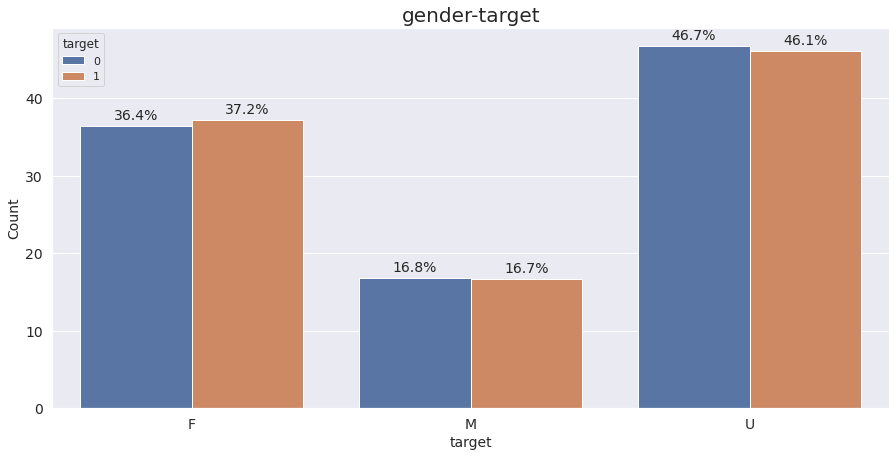

In [ ]:
barplot_with_percentage(x='gender', hue='target', date=df_train) #

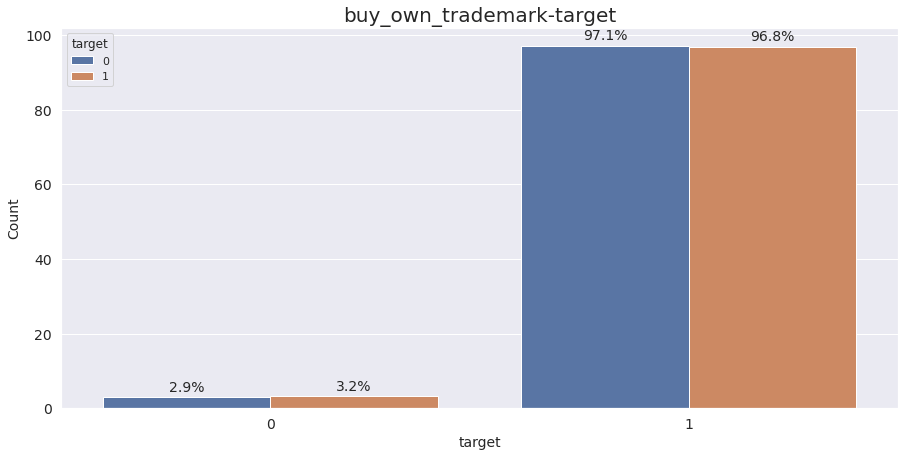

In [ ]:
df_copy = df_train[['count_own_trademark', 'target']].copy() #
df_copy['buy_own_trademark'] = np.int16(df_copy['count_own_trademark'] > 0)
barplot_with_percentage(x='buy_own_trademark', hue='target', date=df_copy)

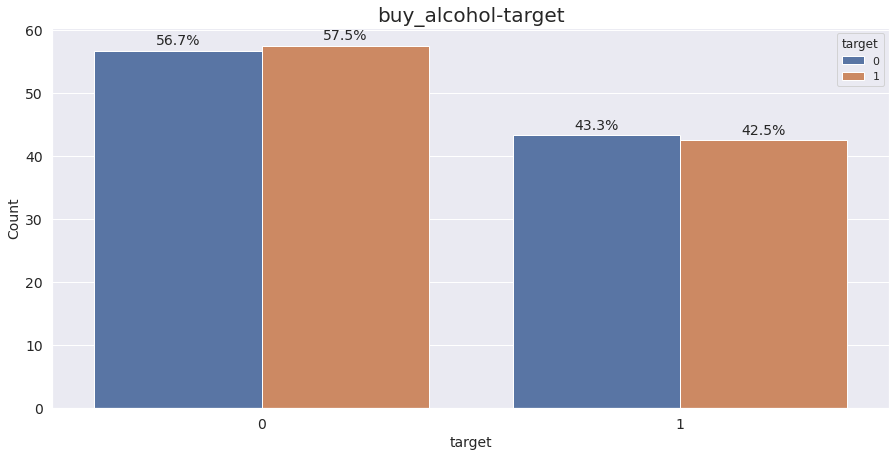

In [ ]:
df_copy = df_train[['count_alcohol', 'target']].copy() #
df_copy['buy_alcohol'] = np.int16(df_copy['count_alcohol'] > 0)
barplot_with_percentage(x='buy_alcohol', hue='target', date=df_copy)

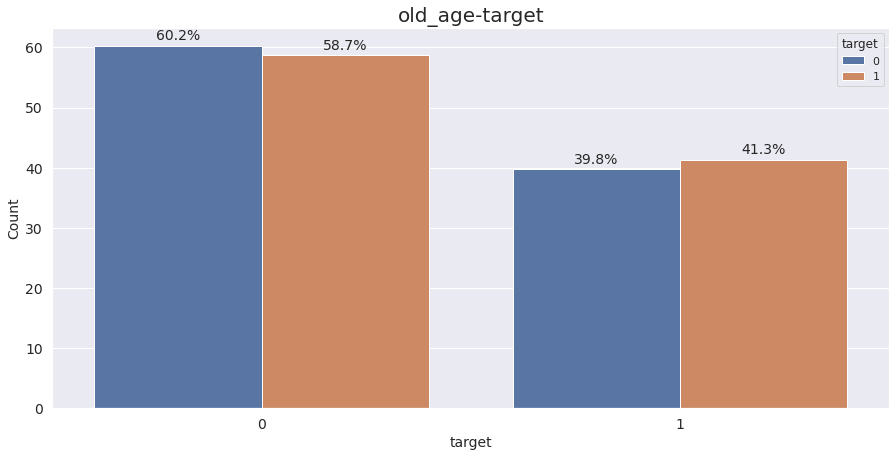

In [ ]:
df_copy = df_train[['age', 'target']].copy() #
df_copy['old_age'] = np.int16(df_copy['age'] > 50)
barplot_with_percentage(x='old_age', hue='target', date=df_copy)

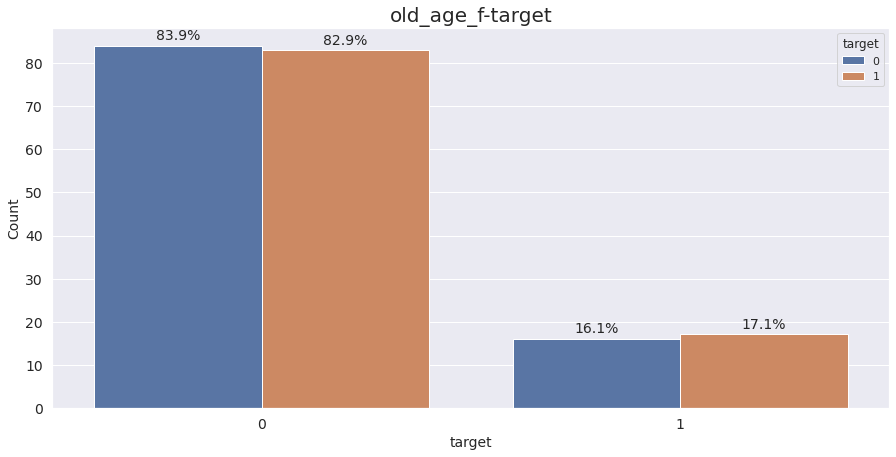

In [ ]:
df_copy = df_train[['age', 'gender', 'target']].copy() #
df_copy['old_age_f'] = np.int16((df_copy['age'] > 50) & (df_copy['gender'] == 'F'))
barplot_with_percentage(x='old_age_f', hue='target', date=df_copy)

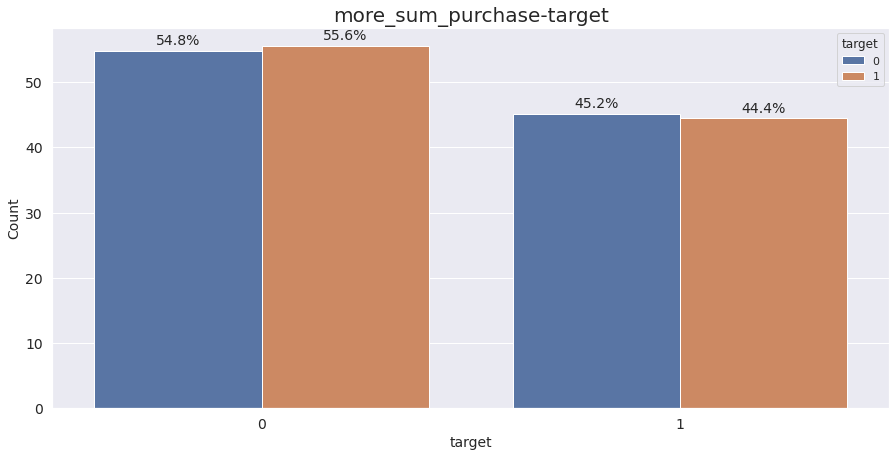

In [ ]:
df_copy = df_train[['mean_purchase_sum', 'target']].copy() #
df_copy['more_sum_purchase'] = np.int16(df_copy['mean_purchase_sum'] > 427)
barplot_with_percentage(x='more_sum_purchase', hue='target', date=df_copy)

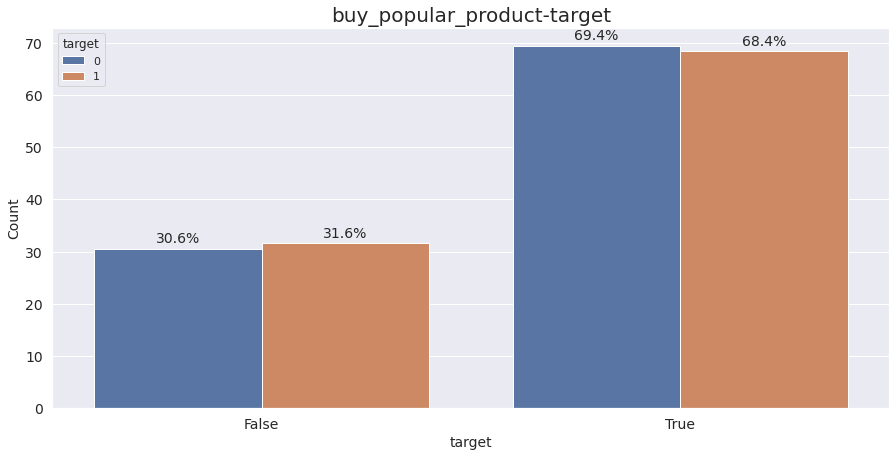

In [ ]:
df_copy = df_train_purch[['client_id', 'product_id']].copy() #
df_copy['buy_popular'] = df_copy['product_id'] == '4009f09b04'
df_copy = df_copy.groupby('client_id').agg(buy_popular_product=('buy_popular', np.any)).reset_index()
df_copy

df_copy = df_copy.merge(df_train[['client_id', 'target']])

barplot_with_percentage(x='buy_popular_product', hue='target', date=df_copy)

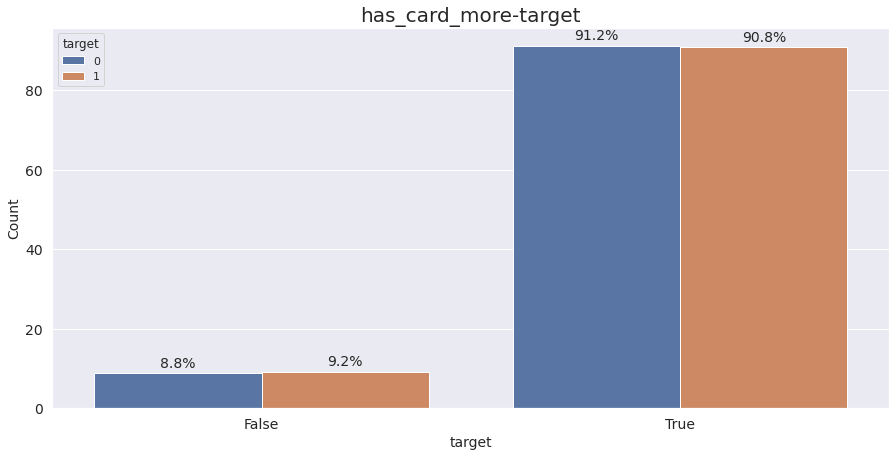

In [ ]:
df_copy = df_train[['first_transaction', 'last_transaction', 'target']].copy() #
df_copy['first_transaction'] = pd.to_datetime(df_copy.first_transaction, format='%Y-%m-%d %H:%M:%S')
df_copy['last_transaction'] = pd.to_datetime(df_copy.first_transaction, format='%Y-%m-%d %H:%M:%S')

df_copy['card_days'] = (df_copy.last_transaction.max() - df_copy.first_transaction).dt.days
df_copy['has_card_more'] = df_copy['card_days'] > 45
barplot_with_percentage(x='has_card_more', hue='target', date=df_copy)

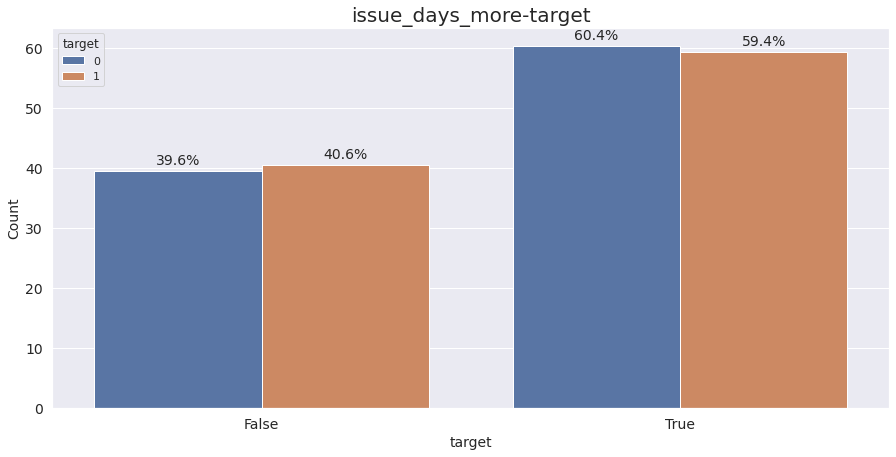

In [ ]:
df_copy = df_train[['first_issue_date', 'first_redeem_date', 'target']].copy() #
df_copy['first_issue_date'] = pd.to_datetime(df_copy.first_issue_date, format='%Y-%m-%d %H:%M:%S')
df_copy['first_redeem_date'] = pd.to_datetime(df_copy.first_redeem_date, format='%Y-%m-%d %H:%M:%S')

df_copy['issue_days'] = (df_copy.first_redeem_date.max() - df_copy.first_issue_date).dt.days
df_copy['issue_days_more'] = df_copy['issue_days'] > 678
barplot_with_percentage(x='issue_days_more', hue='target', date=df_copy)

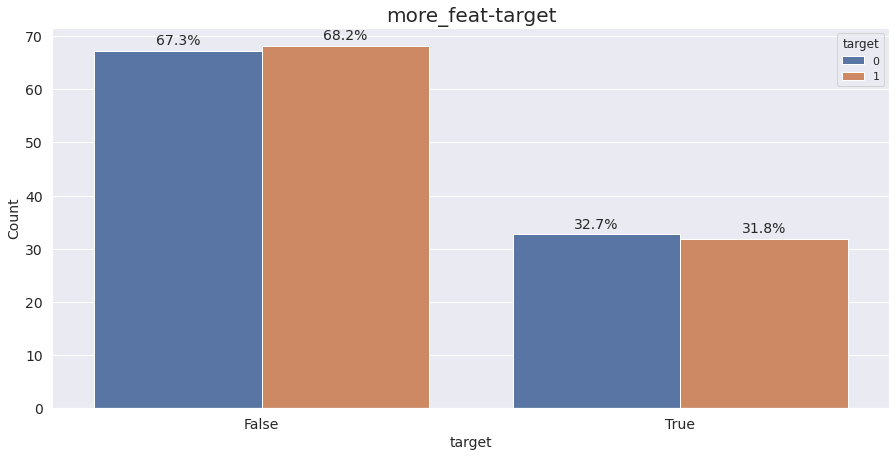

In [ ]:
df_copy = df_train[['sum_regular_points_received', 'target']].copy() #

df_copy['more_feat'] = df_copy['sum_regular_points_received'] > df_copy['sum_regular_points_received'].mean()
barplot_with_percentage(x='more_feat', hue='target', date=df_copy)

In [ ]:
df_copy['sum_regular_points_received'].mean()

77.82280917251674

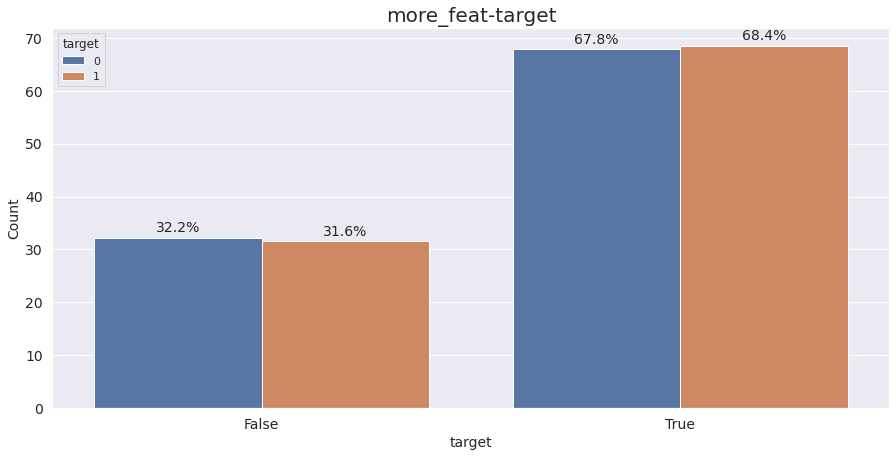

In [ ]:
df_copy = df_train[['sum_regular_points_spent', 'target']].copy()

df_copy['more_feat'] = df_copy['sum_regular_points_spent'] > df_copy['sum_regular_points_spent'].mean()
barplot_with_percentage(x='more_feat', hue='target', date=df_copy)

In [ ]:
df_copy['sum_regular_points_spent'].mean()

-73.13311004306313

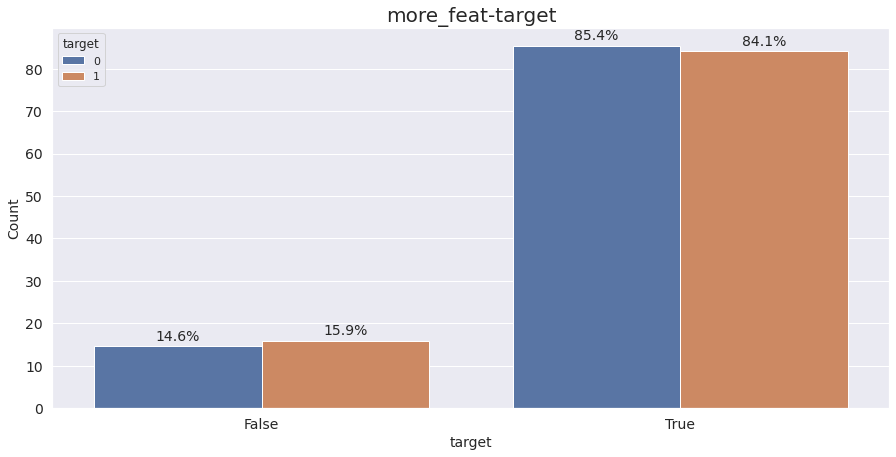

In [ ]:
df_copy = df_train[['mean_express_points_spent', 'target']].copy()

df_copy['more_feat'] = df_copy['mean_express_points_spent'] > df_copy['mean_express_points_spent'].mean()
barplot_with_percentage(x='more_feat', hue='target', date=df_copy)

In [ ]:
df_copy['mean_express_points_spent'].mean()

-0.6323366162949678

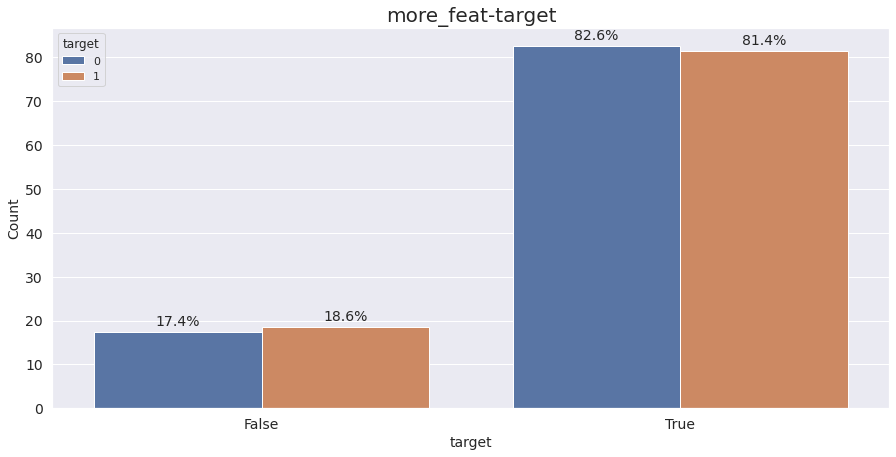

In [ ]:
df_copy = df_train[['sum_express_points_spent', 'target']].copy() #

df_copy['more_feat'] = df_copy['sum_express_points_spent'] > df_copy['sum_express_points_spent'].mean()
barplot_with_percentage(x='more_feat', hue='target', date=df_copy)

In [ ]:
df_copy['sum_express_points_spent'].mean()

-6.45631913845187

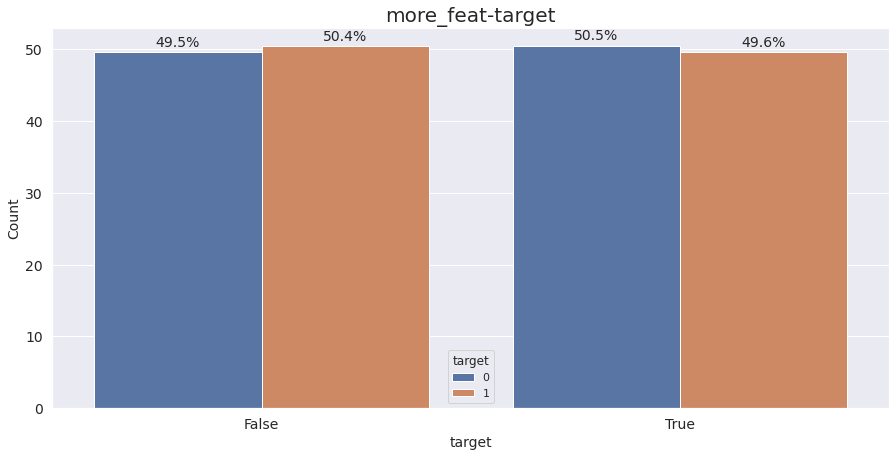

In [ ]:
df_copy = df_train[['mean_purchase_sum', 'target']].copy() #

df_copy['more_feat'] = df_copy['mean_purchase_sum'] > df_copy['mean_purchase_sum'].median()
barplot_with_percentage(x='more_feat', hue='target', date=df_copy)

In [ ]:
df_copy['mean_purchase_sum'].median()

393.5576190476191

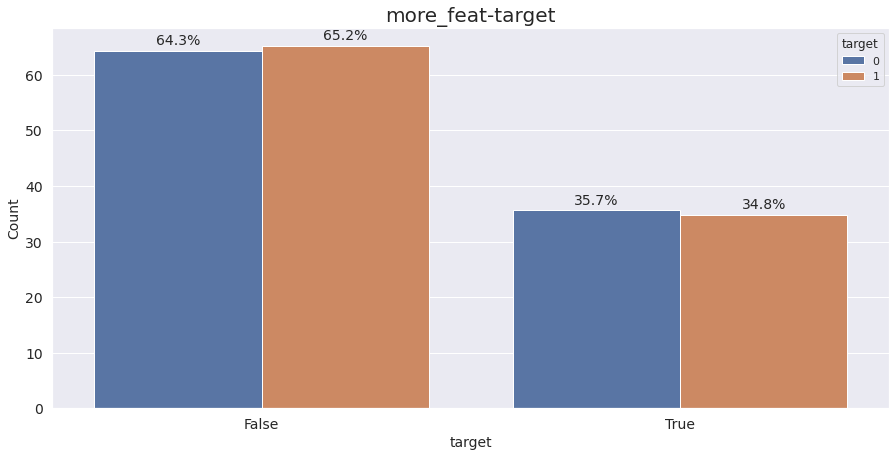

In [ ]:
df_copy = df_train[['sum_purchase_sum', 'target']].copy()

df_copy['more_feat'] = df_copy['sum_purchase_sum'] > df_copy['sum_purchase_sum'].mean()
barplot_with_percentage(x='more_feat', hue='target', date=df_copy)

In [ ]:
 df_copy['sum_purchase_sum'].mean()

8584.204814285818

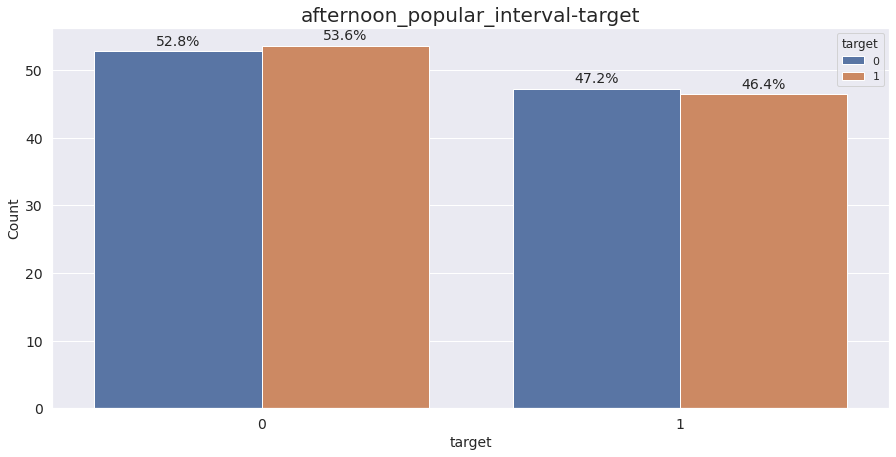

In [ ]:
df_copy = df_train[['afternoon', 'evening', 'morning', 'night', 'target']].copy()
df_copy['popular_interval'] = df_copy[['afternoon', 'evening', 'morning', 'night']].idxmax(1)
df_copy['afternoon_popular_interval'] = np.int16(df_copy['popular_interval'] == 'afternoon')

barplot_with_percentage(x='afternoon_popular_interval', hue='target', date=df_copy)

## Feature engineering

In [ ]:
df_train_purch

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15998947,fffeca6d22,a0bb11a968,2019-03-09 07:47:43,0.4,0.0,0.0,0.0,99.0,a0613e36b5,de437430e2,1.0,19.0,NaN
15998948,fffeca6d22,a0bb11a968,2019-03-09 07:47:43,0.4,0.0,0.0,0.0,99.0,a0613e36b5,ad8fee4200,1.0,45.0,NaN
15998949,fffeca6d22,3b876a5532,2019-03-15 14:46:39,0.8,0.0,0.0,0.0,165.0,a0613e36b5,ad8fee4200,2.0,94.0,NaN
15998950,fffeca6d22,3b876a5532,2019-03-15 14:46:39,0.8,0.0,0.0,0.0,165.0,a0613e36b5,230dbb0c16,1.0,50.0,NaN


**Генерация признаков**
- Различные группы людей (возраст + пол) (+)
- Количество дней владения картой клиента (+)
- Клиент владеет картой больше 45 дней (+)
- Интервал дней между first_issue_date first_redeem_date (+)
- Все времена в unixtime (+)
- Признак, который отмечает nan значениями (+)
- Покупка популярного level2 ... level4 (+)
- Покупка популярного товара (+)
- Количество купленого алкоголя (+)
- Брал алкоголь хотя бы раз (+)
- Количество купленого товара собственного производства (+)
- Брал товар собственного производства хотя бы раз (+)
- Стоимость покупок выше среднего чека (+)
- Доля покупок с обычными баллами (+)
- Доля покупок с экстра баллами (+)
- Доля покупок с полученными обычными баллами (+)
- Доля покупок с полученными экстра баллами (+)
- Количество уникальных магазинов клиента (+)
- Количество потраченных/полученных баллов и потраченных денег за последний месяц (+)
- Количество потраченных/полученных баллов и потраченных денег за последние два месяца (+)
- Разница количество потраченных/полученных между интервалами выше (+)

**Допполнительные признаки**
- Сколько раз сумма покупок больше 500р, 1000р, 1500р (+)
- Сколько различных товаров покупает клиент (+)
- Доля алкоголя из купленных товаров (+)
- Доля товаров собственного производства из купленных товаров (+)
- Количество прошедшего времени с first_issue_date и first_redeem_date до последний даты в транзакциях (+)
- Средний интервал между походами в магазин (+)
- Количество товаров собственного производства до и после first_redeem_date (+)
- Количество товаров алкоголя до и после first_redeem_date (+)
- Количество товаров собственного производства до и после среднего времени всех транзакций клтента (+)
- Количество товаров алкоголя до и после среднего времени всех транзакций клтента (+)

-- Дополнительно попробовать убрать выбросы

-- Попробовать PCA, T-SNE

-- Попробовать нелинейный scale, log(1 + x)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140027 entries, 0 to 140026
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   client_id                       140027 non-null  object        
 1   afternoon                       140027 non-null  int64         
 2   evening                         140027 non-null  int64         
 3   morning                         140027 non-null  int64         
 4   night                           140027 non-null  int64         
 5   mean_netto                      140027 non-null  float64       
 6   sum_netto                       140027 non-null  float64       
 7   count_own_trademark             140027 non-null  int64         
 8   count_alcohol                   140027 non-null  int64         
 9   mean_regular_points_received    140027 non-null  float64       
 10  std_regular_points_received     137324 non-null  float64

In [ ]:
def create_feats(date_proc, is_train=True, ad_random=False):
    date_proc['old_age'] = np.int16(date_proc['age'] > 50)
    date_proc['old_age_f'] = np.int16((date_proc['age'] > 50) & (date_proc['gender'] == 'F'))

    # time normalize
    date_proc['first_transaction_unix'] = date_proc['first_transaction'].view('int64') // (10 ** 9)
    date_proc['last_transaction_unix'] = date_proc['last_transaction'].view('int64') // (10 ** 9)
    date_proc['first_issue_date_unix'] = date_proc['first_issue_date'].view('int64') // (10 ** 9)
    date_proc['first_redeem_date_unix'] = date_proc['first_redeem_date'].view('int64') // (10 ** 9)
    
    # pred last transaction (before max value time) 
    if is_train:
        temp = df_train_purch[['client_id', 'transaction_datetime']].drop_duplicates()
    else:
        temp = df_test_purch[['client_id', 'transaction_datetime']].drop_duplicates()
    temp.transaction_datetime = pd.to_datetime(temp.transaction_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
    temp['max_transaction_datetime'] = temp.groupby('client_id')['transaction_datetime'].transform('max')
    pred_last_trans = temp[temp.transaction_datetime < temp.max_transaction_datetime]\
        .groupby('client_id').agg(pred_last_transaction_datetime=('transaction_datetime', 'max')).reset_index()

    date_proc = pred_last_trans.merge(date_proc, how='right')
    date_proc.pred_last_transaction_datetime = date_proc.pred_last_transaction_datetime.view('int64') // (10 ** 9)
    
    date_proc['days_own'] = (date_proc.pred_last_transaction_datetime - date_proc.first_redeem_date_unix)
    date_proc['days_from_last_trans'] = (date_proc.last_transaction_unix - date_proc.pred_last_transaction_datetime)
    
    # ordinal representation datetime
    last_date = date.toordinal(date(2019, 3, 19))
    date_proc['ordinal_first_issue_date'] = last_date - date_proc.first_issue_date.apply(lambda x: date.toordinal(x))
    date_proc['ordinal_first_redeem_date'] = last_date - date_proc.first_redeem_date.apply(lambda x: date.toordinal(x))
    
    # count buy statistic after and before (first_redeem_date)
    if is_train:
        temp = df_train_purch[['client_id', 'transaction_id', 'transaction_datetime', 'product_id']]\
            .merge(df_products[['product_id', 'is_own_trademark', 'is_alcohol']])
        temp = temp.merge(date_proc[['client_id', 'first_redeem_date']], how='left')
    else:
        temp = df_test_purch[['client_id', 'transaction_id', 'transaction_datetime', 'product_id']]\
            .merge(df_products[['product_id', 'is_own_trademark', 'is_alcohol']])
        temp = temp.merge(date_proc[['client_id', 'first_redeem_date']], how='left')

    date_proc = temp[temp.transaction_datetime < temp.first_redeem_date]\
        .groupby('client_id').agg(before_fr_count_own=('is_own_trademark', 'sum'),
                                  before_fr_count_alcohol=('is_alcohol', 'sum'),
                                  before_fr_count_product=('product_id', 'count'))\
                                    .reset_index().merge(date_proc, how='right')
    date_proc = temp[temp.transaction_datetime >= temp.first_redeem_date]\
        .groupby('client_id').agg(after_fr_count_own=('is_own_trademark', 'sum'),
                                  after_fr_count_alcohol=('is_alcohol', 'sum'),
                                  after_fr_count_product=('product_id', 'count'))\
                                    .reset_index().merge(date_proc, how='right')
    date_proc.fillna(0, inplace=True)
    
    # count buy statistic after and before (mean first_redeem_date)
    if is_train:
        temp = df_train_purch[['client_id', 'transaction_id', 'transaction_datetime', 'product_id']]\
                .merge(df_products[['product_id', 'is_own_trademark', 'is_alcohol']])
    else:
        temp = df_test_purch[['client_id', 'transaction_id', 'transaction_datetime', 'product_id']]\
                .merge(df_products[['product_id', 'is_own_trademark', 'is_alcohol']])
    temp = temp.merge(temp[['client_id', 'transaction_datetime']].drop_duplicates()\
        .groupby('client_id').agg(mean_transaction_datetime=('transaction_datetime', 'mean')).reset_index(),
                    how='left')
    
    date_proc = date_proc.merge(temp[temp.transaction_datetime < temp.mean_transaction_datetime].groupby('client_id')\
                    .agg(before_mean_own=('is_own_trademark', 'sum'),
                         before_mean_alcohol=('is_alcohol', 'sum'),
                         before_count_purches=('product_id', 'count')).reset_index(), how='left')
    date_proc = date_proc.merge(temp[temp.transaction_datetime >= temp.mean_transaction_datetime].groupby('client_id')\
                    .agg(after_mean_own=('is_own_trademark', 'sum'),
                         after_mean_alcohol=('is_alcohol', 'sum'),
                         after_count_purches=('product_id', 'count')).reset_index(), how='left')
    date_proc['diff_mean_own'] = date_proc['after_mean_own'] - date_proc['before_mean_own']
    date_proc['diff_mean_alcohol'] = date_proc['after_mean_alcohol'] - date_proc['before_mean_alcohol']
    date_proc['diff_count_purches'] = date_proc['after_count_purches'] - date_proc['before_count_purches']
    
    # card days and issue days
    #date_proc['card_days'] = (date_proc.first_redeem_date - date_proc.first_transaction).dt.days
    date_proc['card_days'] = (date_proc.last_transaction.max() - date_proc.first_redeem_date).dt.days
    date_proc['has_card_more'] = np.int16(date_proc['card_days'] > 100)
    
    date_proc['issue_days'] = (date_proc.last_transaction.max() - date_proc.first_issue_date).dt.days
    date_proc['issue_days_more'] = np.int16(date_proc['issue_days'] > 678)
    
    # buy popular product level 
    if is_train:
        temp = df_train_purch[['client_id', 'transaction_id', 'transaction_datetime', 'product_id']].merge(df_products)
    else:
        temp = df_test_purch[['client_id', 'transaction_id', 'transaction_datetime', 'product_id']].merge(df_products)
    
    popular_level = ['e344ab2e71', 'ad2b2e17d2', 'ca69ed9de2', '146717c1b2']
    for i in range(4, 3, -1):
        temp[f'buy_popular_level_{i}'] = temp[f'level_{i}'] == popular_level[i-1]
        date_proc = temp.groupby('client_id')[f'buy_popular_level_{i}'].any().reset_index().merge(date_proc)
        date_proc[f'buy_popular_level_{i}'] = np.int16(date_proc[f'buy_popular_level_{i}'])
    
    # buy popular product_id
    if is_train:
        temp = df_train_purch[['client_id', 'product_id']].copy()
    else:
        temp = df_test_purch[['client_id', 'product_id']].copy()
    temp['buy_popular'] = temp['product_id'] == '4009f09b04'
    date_proc = temp.groupby('client_id').agg(buy_popular_product=('buy_popular', np.any)).reset_index().merge(date_proc)
    date_proc['buy_popular_product'] = np.int16(date_proc['buy_popular_product'])
    
    date_proc['buy_alcohol'] = np.int16(date_proc['count_alcohol'] > 0)
    date_proc['buy_own_trademark'] = np.int16(date_proc['count_own_trademark'] > 0)
    date_proc['more_sum_purchase'] = np.int16(date_proc['mean_purchase_sum'] > 427)
    
    # procent use regular and express points
    if is_train:
        temp = df_train_purch[['client_id', 'transaction_id',
                               'regular_points_received', 'express_points_received',
                               'regular_points_spent', 'express_points_spent']].drop_duplicates()
    else:
        temp = df_test_purch[['client_id', 'transaction_id',
                               'regular_points_received', 'express_points_received',
                               'regular_points_spent', 'express_points_spent']].drop_duplicates()
    temp['proc_regular_points_received'] = temp['regular_points_received'] > 0
    temp['proc_express_points_received'] = temp['express_points_received'] > 0
    temp['proc_regular_points_spent'] = temp['regular_points_spent'] < 0
    temp['proc_express_points_spent'] = temp['express_points_spent'] < 0
    
    date_proc = temp.groupby('client_id')['proc_regular_points_received'].mean().reset_index().merge(date_proc)
    date_proc = temp.groupby('client_id')['proc_express_points_received'].mean().reset_index().merge(date_proc)
    date_proc = temp.groupby('client_id')['proc_regular_points_spent'].mean().reset_index().merge(date_proc)
    date_proc = temp.groupby('client_id')['proc_express_points_spent'].mean().reset_index().merge(date_proc)
    date_proc['proc_regular_points_received'] *= 100
    date_proc['proc_express_points_received'] *= 100
    date_proc['proc_regular_points_spent'] *= 100
    date_proc['proc_express_points_spent'] *= 100
    
    # count unique store
    if is_train:
        temp = df_train_purch[['client_id', 'store_id']].drop_duplicates()
    else:
        temp = df_test_purch[['client_id', 'store_id']].drop_duplicates()
    date_proc = temp.groupby('client_id').agg(count_store=('store_id', 'count')).reset_index().merge(date_proc)
    
    # trn_sum_from_iss and trn_sum_from_red
    if is_train:
        temp = df_train_purch[['client_id', 'trn_sum_from_iss', 'trn_sum_from_red']].copy()
    else:
        temp = df_test_purch[['client_id', 'trn_sum_from_iss', 'trn_sum_from_red']].copy()
    temp.trn_sum_from_red.fillna(0, inplace=True)
    date_proc = temp.groupby('client_id').agg(mean_trn_sum_from_iss=('trn_sum_from_iss', 'mean'),
                                              std_trn_sum_from_iss=('trn_sum_from_iss', 'std'),
                                              median_trn_sum_from_iss=('trn_sum_from_iss', 'median'),
                                              sum_trn_sum_from_iss=('trn_sum_from_iss', 'sum'),
                                              mean_trn_sum_from_red=('trn_sum_from_red', 'mean'),
                                              std_trn_sum_from_red=('trn_sum_from_red', 'std'),
                                              median_trn_sum_from_red=('trn_sum_from_red', 'median'),
                                              sum_trn_sum_from_red=('trn_sum_from_red', 'sum'))\
                                                .reset_index().merge(date_proc)
    
    
    
    # static last month, last before month, diffs
    if is_train:
        temp = df_train_purch[['client_id', 'transaction_id', 'transaction_datetime',
                               'regular_points_received', 'express_points_received',
                               'regular_points_spent', 'express_points_spent', 'purchase_sum']].drop_duplicates()
    else:
        temp = df_test_purch[['client_id', 'transaction_id', 'transaction_datetime',
                               'regular_points_received', 'express_points_received',
                               'regular_points_spent', 'express_points_spent', 'purchase_sum']].drop_duplicates()
    temp.transaction_datetime = pd.to_datetime(temp.transaction_datetime, format='%Y-%m-%d %H:%M:%S')
    temp['transaction_time_ago'] = temp.transaction_datetime.max() - temp.transaction_datetime
    temp['last_month'] = temp.transaction_time_ago < pd.Timedelta('31d')
    temp['last_two_month'] = temp.transaction_time_ago < pd.Timedelta('61d')
    client_last_month = temp[temp.last_month].groupby('client_id')\
            .agg(last_month_regular_points_received=('regular_points_received', 'sum'),
                 last_month_express_points_received=('express_points_received', 'sum'),
                 last_month_regular_points_spent=('regular_points_spent', 'sum'),
                 last_month_express_points_spent=('express_points_spent', 'sum'),
                 last_month_purchase_sum=('purchase_sum', 'sum')).reset_index()
    date_proc = date_proc.merge(client_last_month, how='left').fillna(0)
    client_last_two_month = temp[temp.last_two_month].groupby('client_id')\
            .agg(last_two_month_regular_points_received=('regular_points_received', 'sum'),
                 last_two_month_express_points_received=('express_points_received', 'sum'),
                 last_two_month_regular_points_spent=('regular_points_spent', 'sum'),
                 last_two_month_express_points_spent=('express_points_spent', 'sum'),
                 last_two_month_purchase_sum=('purchase_sum', 'sum')).reset_index()
    date_proc = date_proc.merge(client_last_two_month, how='left').fillna(0)
    
    date_proc['before_month_regular_points_received'] = date_proc.last_two_month_regular_points_received \
        - date_proc.last_month_regular_points_received
    date_proc['before_month_express_points_received'] = date_proc.last_two_month_express_points_received \
        - date_proc.last_month_express_points_received
    date_proc['before_month_regular_points_spent'] = date_proc.last_two_month_regular_points_spent \
        - date_proc.last_month_regular_points_spent
    date_proc['before_month_express_points_spent'] = date_proc.last_two_month_express_points_spent \
        - date_proc.last_month_express_points_spent
    date_proc['before_month_purchase_sum'] = date_proc.last_two_month_purchase_sum \
        - date_proc.last_month_purchase_sum
    
    date_proc['diff_month_regular_points_received'] = date_proc.last_month_regular_points_received \
        - date_proc.before_month_regular_points_received
    date_proc['diff_month_express_points_received'] = date_proc.last_month_express_points_received \
        - date_proc.before_month_express_points_received
    date_proc['diff_month_regular_points_spent'] = date_proc.last_month_regular_points_spent \
        - date_proc.before_month_regular_points_spent
    date_proc['diff_month_express_points_spent'] = date_proc.last_month_express_points_spent \
        - date_proc.before_month_express_points_spent
    date_proc['diff_month_purchase_sum'] = date_proc.last_month_purchase_sum \
        - date_proc.before_month_purchase_sum
    
    # count purchase more 500, 1000, 1500
    if is_train:
        temp = df_train_purch[['client_id', 'transaction_id', 'purchase_sum']].drop_duplicates()
    else:
        temp = df_test_purch[['client_id', 'transaction_id', 'purchase_sum']].drop_duplicates()
    temp['buy_more500_times'] = np.int16(temp.purchase_sum > 500)
    temp['buy_more1000_times'] = np.int16(temp.purchase_sum > 1000)
    temp['buy_more1500_times'] = np.int16(temp.purchase_sum > 1500)
    date_proc = temp.groupby('client_id')[['buy_more500_times',
                                      'buy_more1000_times',
                                      'buy_more1500_times']].sum().reset_index().merge(date_proc)
    
    # more mean purchases
    if is_train:
        temp = df_train_purch[['client_id', 'transaction_id', 'purchase_sum']].drop_duplicates()
    else:
        temp = df_test_purch[['client_id', 'transaction_id', 'purchase_sum']].drop_duplicates()
    temp['more_mean_purchase_sum_proc'] = temp.purchase_sum > 427
    temp = temp.groupby('client_id')['more_mean_purchase_sum_proc'].mean().reset_index()
    temp['more_mean_purchase_sum'] = np.int16(temp['more_mean_purchase_sum_proc'] > 0.5)
    date_proc = temp.merge(date_proc)
    
    # count unique products
    if is_train:
        temp = df_train_purch[['client_id', 'product_id']].drop_duplicates()
    else:
        temp = df_test_purch[['client_id', 'product_id']].drop_duplicates()
    date_proc = temp.groupby('client_id').agg(unique_products=('product_id', 'count')).reset_index().merge(date_proc)
    
    # procent of purchases with own and alcohol
    if is_train:
        temp = df_train_purch[['client_id', 'transaction_id', 'product_quantity', 'product_id']].drop_duplicates()\
            .merge(df_products[['product_id', 'is_own_trademark', 'is_alcohol']].copy())
    else:
        temp = df_test_purch[['client_id', 'transaction_id', 'product_quantity', 'product_id']].drop_duplicates()\
            .merge(df_products[['product_id', 'is_own_trademark', 'is_alcohol']].copy())

    temp['buy_own_trademark_proc'] = temp['product_quantity'] * temp['is_own_trademark']
    temp['buy_alcohol_proc'] = temp['product_quantity'] * temp['is_alcohol']
    temp = temp.groupby('client_id')[['product_quantity',
                                      'buy_own_trademark_proc',
                                      'buy_alcohol_proc']].sum().reset_index()
    temp.loc[temp.product_quantity == 0, 'product_quantity'] = 1
    temp['buy_own_trademark_proc'] /= temp['product_quantity'] * 100
    temp['buy_alcohol_proc'] /= temp['product_quantity'] * 100
    date_proc = temp[['client_id', 'buy_own_trademark_proc', 'buy_alcohol_proc']].merge(date_proc)
    
    # mean interval between transactions
    if is_train:
        temp = df_train_purch[['client_id', 'transaction_datetime']].drop_duplicates()
    else:
        temp = df_test_purch[['client_id', 'transaction_datetime']].drop_duplicates()
    temp['transaction_datetime'] = pd.to_datetime(temp.transaction_datetime, format='%Y-%m-%d %H:%M:%S')
    temp['mean_interval_transaction'] = temp['transaction_datetime'].apply(lambda x: date.toordinal(x))
    date_proc = temp.groupby('client_id')['mean_interval_transaction']\
        .apply(list).apply(np.diff).apply(lambda x: np.mean(x) if len(x) > 0 else 0)\
        .reset_index().merge(date_proc)
    
    # more mean value for point and sum
    date_proc['more_regular_points_received'] = np.int16(date_proc['sum_regular_points_received'] > 77.8)
    date_proc['more2_mean_purchase_sum'] = np.int16(date_proc['mean_purchase_sum'] > 393.5)
    date_proc['more_express_points_spent'] = np.int16(date_proc['sum_express_points_spent'] > -6.45)
    
    # gender OHE
    date_proc = pd.concat([date_proc, pd.get_dummies(date_proc.gender, prefix="gender")], axis=1)
    
    # mean_netto > 10 # 16
    date_proc['more_mean_netto'] = np.int16(date_proc['mean_netto'] > 10)
    # buy_own_trademark_proc == 0
    date_proc['zero_buy_own_trademark_proc'] = np.int16(date_proc['buy_own_trademark_proc'] == 0)
    # unique_products == 1
    date_proc['one_unique_products'] = np.int16(date_proc['unique_products'] == 1)
    # proc_regular_points_received == 0
    date_proc['one_proc_regular_points_received'] = np.int16(date_proc['proc_regular_points_received'] == 0)
    # proc_express_points_received > 15
    date_proc['more_proc_express_points_received'] = np.int16(date_proc['proc_express_points_received'] > 15)
    # before_fr_count_alcohol > 60
    date_proc['more_before_fr_count_alcohol'] = np.int16(date_proc['before_fr_count_alcohol'] > 60)
    # after_fr_count_alcohol > 100
    date_proc['more_after_fr_count_alcohol'] = np.int16(date_proc['after_fr_count_alcohol'] > 100)
    # mean_regular_points_received == 0
    date_proc['zero_mean_regular_points_received'] = np.int16(date_proc['mean_regular_points_received'] == 0)
    # std_regular_points_received > 100
    date_proc['more_std_regular_points_received'] = np.int16(date_proc['std_regular_points_received'] > 100)
    # more median
    date_proc['more_median_purchase_sum'] = np.int16(date_proc.mean_purchase_sum > date_proc.sum_purchase_sum)
    
    
    # Выбранные полезные фичи
    select_feat = ['ordinal_first_redeem_date',
                   'first_redeem_date_unix',
                   'card_days',
                   'days_own',
                   'after_fr_count_product',
                   'after_fr_count_own',
                   'old_age',
                   'more_express_points_spent',
                   'sum_express_points_spent',
                   'mean_trn_sum_from_iss',
                   'last_month_regular_points_received',
                   'old_age_f',
                   'last_transaction_unix',
                   'last_two_month_express_points_spent',
                   'diff_month_purchase_sum',
                   'diff_mean_own',
                   'sum_regular_points_spent',
                   'sum_regular_points_received',
                   'median_trn_sum_from_iss',
                   'last_two_month_purchase_sum',
                   'count_own_trademark',
                   'diff_count_purches',
                   'count_store',
                   'before_month_express_points_spent',
                   'last_month_express_points_spent',
                   'last_two_month_regular_points_spent',
                   'buy_alcohol',
                   'before_month_regular_points_spent',
                   'ordinal_first_issue_date',
                   'unique_products',
                   'median_express_points_spent',
                   'after_mean_own',
                   'issue_days',
                   'evening',
                   'gender_U',
                   'has_card_more',
                   'more_regular_points_received',
                   'after_count_purches',
                   'proc_regular_points_spent',
                   'std_trn_sum_from_red',
                   'std_express_points_spent',
                   'sum_trn_sum_from_iss',
                   'median_trn_sum_from_red',
                   'mean_netto',
                   'buy_own_trademark_proc',
                   'more2_mean_purchase_sum',
                   'diff_month_express_points_spent',
                   'std_regular_points_received',
                   'median_regular_points_received',
                   'proc_express_points_spent',
                   'pred_last_transaction_datetime',
                   'std_trn_sum_from_iss',
                   'median_purchase_sum',
                   'before_fr_count_product',
                   'zero_buy_own_trademark_proc',
                   'sum_trn_sum_from_red',
                   'last_month_regular_points_spent',
                   'count_alcohol',
                   'issue_days_more',
                   'before_fr_count_own',
                   'before_count_purches',
                   'mean_regular_points_received',
                   'age',
                   'mean_interval_transaction',
                   'diff_month_regular_points_spent',
                   'buy_popular_product',
                   'mean_express_points_received',
                   'sum_purchase_sum',
                   'mean_trn_sum_from_red',
                   'mean_regular_points_spent',
                   'last_two_month_express_points_received',
                   'diff_month_regular_points_received',
                   'one_unique_products',
                   'before_month_regular_points_received',
                   'more_std_regular_points_received',
                   'after_fr_count_alcohol',
                   'night',
                   'afternoon',
                   'mean_purchase_sum',
                   'morning',
                   'buy_more1000_times',
                   'before_mean_own',
                   'std_express_points_received',
                   'last_month_express_points_received',
                   'proc_express_points_received',
                   'after_mean_alcohol',
                   'more_before_fr_count_alcohol',
                   'median_regular_points_spent',
                   'buy_more1500_times',
                   'sum_netto',
                   'sum_express_points_received',
                   'more_proc_express_points_received',
                   'more_sum_purchase',
                   'diff_mean_alcohol',
                   'buy_own_trademark',
                   'median_express_points_received',
                   'more_mean_purchase_sum_proc',
                   'more_mean_purchase_sum']
    
    date_proc.drop(['client_id', 'first_transaction', 'last_transaction', 'first_issue_date', 'first_redeem_date',
                   'gender', 'buy_more500_times'], axis=1, inplace=True)
    date_proc.fillna(0, inplace=True)
    
    if is_train:
        select_feat += ['target']
    
    if is_train and ad_random:
        date_proc['random_feat'] = np.random.randn(date_proc.shape[0]) * 5
    return date_proc[select_feat]

In [ ]:
x_date = create_feats(df_train.copy(), ad_random=False)
y_date = x_date['target']
x_date.drop(['target'], axis=1, inplace=True)
feats = list(x_date)
print(df_train.shape, x_date.shape)
x_date.head()

(140027, 36) (140027, 98)


,ordinal_first_redeem_date,first_redeem_date_unix,card_days,days_own,after_fr_count_product,after_fr_count_own,old_age,more_express_points_spent,sum_express_points_spent,mean_trn_sum_from_iss,...,buy_more1500_times,sum_netto,sum_express_points_received,more_proc_express_points_received,more_sum_purchase,diff_mean_alcohol,buy_own_trademark,median_express_points_received,more_mean_purchase_sum_proc,more_mean_purchase_sum
0,439,1515094207,438,36945716,52.0,4.0,0,1,0.0,53.942308,...,0,28.092,0.0,0,1,0.0,1,0.0,0.750000,1
1,695,1492951076,694,59176095,162.0,14.0,1,1,0.0,60.555556,...,0,78.064,60.0,0,0,1.0,1,0.0,0.281250,0
2,203,1535461185,202,17098176,86.0,10.0,0,1,0.0,71.569767,...,0,41.611,0.0,0,0,0.0,1,0.0,0.400000,0
3,433,1515606605,432,36943353,272.0,44.0,1,0,-30.0,92.669118,...,8,131.152,0.0,0,1,0.0,1,0.0,0.833333,1
4,166,1538665169,165,13657256,85.0,16.0,0,1,0.0,101.317647,...,0,30.423,0.0,0,1,1.0,1,0.0,0.533333,1


In [ ]:
# scaler = StandardScaler()
# scaler = PowerTransformer()
# scaler.fit(x_date)
# x_date = scaler.transform(x_date)

In [ ]:
print(df_test.shape)
X_test = create_feats(df_test.copy(), False)
X_test.shape

(60012, 35)


(60012, 98)

In [ ]:
# X_test = scaler.transform(X_test)

## Modeling

In [ ]:
# catboost
MODEL_CATBOOST_CONST_PARAM = dict({
    'task_type': 'GPU' if get_gpu_device_count() else 'CPU',
    #'thread_count': 2,
    'eval_metric': 'Logloss', # AUC
    'loss_function': 'Logloss',
    'iterations': 700, # 2000
    'early_stopping_rounds': 10, # 20
    'random_seed': 2023})

# xgboost
MODEL_XGB_CONST_PARAM = dict({
    'eval_metric': 'logloss',
    'early_stopping_rounds': 10,
    'seed': 2023})

# lightgbm
MODEL_LIGHT_CONST_PARAM = dict({
#     'eval_metric': 'logloss',
    'early_stopping_round': 10,
    'seed': 2023})

# rf
MODEL_RF_CONST_PARAM = dict({
#     'early_stopping_round': 15,
    'random_state': 2023,
    'n_jobs': 4})

# GBM
MODEL_GBM_CONST_PARAM = dict({
#     'early_stopping_round': 15,
    'random_state': 2023
    })

Error 35 (CUDA driver version is insufficient for CUDA runtime version) ignored while obtaining device count


In [ ]:
# catboost
HYPEROPT_CATBOOST_PARAMS_SPACE = {
    'learning_rate': hyperopt.hp.uniform('learning_rate', 0.03, 0.3),
    'depth': hyperopt.hp.randint('depth', 3, 9),
    'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 1, 10),
    'max_ctr_complexity': hyperopt.hp.randint('max_ctr_complexity', 1, 16),
    'min_data_in_leaf': hyperopt.hp.randint('min_data_in_leaf', 10, 100),
#     'max_leaves': hyperopt.hp.randint('max_leaves', 100, 1000),
    #'grow_policy': hyperopt.hp.choice('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
    'subsample': hyperopt.hp.uniform('subsample', 0.7, 1),
#     'od_wait': hyperopt.hp.randint('od_wait', 20, 100)
    
}

# xgboost
HYPEROPT_XGB_PARAMS_SPACE = {
    'eta': hyperopt.hp.uniform('eta', 0.01, 0.35),
    'max_depth': hyperopt.hp.randint('max_depth', 3, 9),
    'lambda': hyperopt.hp.uniform('lambda', 1, 10),
    'min_child_weight': hyperopt.hp.choice('min_child_weight', [1, 3, 5, 7]),
    "gamma": hyperopt.hp.choice('gamma', [0.0, 0.1, 0.2, 0.3, 0.4]),
    #"n_estimators": hyperopt.hp.choice('n_estimators', [100, 200, 500, 1000])
    #"colsample_bytree": hyperopt.hp.choice('colsample_bytree', [0.3, 0.4, 0.5, 0.7])
    #'max_ctr_complexity': hyperopt.hp.randint('max_ctr_complexity', 0, 8)
}

# lightgbm
HYPEROPT_LIGHT_PARAMS_SPACE = {
    'num_leaves': hyperopt.hp.randint('num_leaves', 6, 50),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 0.05, 0.35),
    'max_depth': hyperopt.hp.randint('max_depth', 3, 9),
    'min_child_samples': hyperopt.hp.randint('min_child_samples', 20, 150),
    'min_child_weight': hyperopt.hp.uniform('min_child_weight', 0.001, 0.1),#hyperopt.hp.choice('min_child_weight', [1, 3, 5, 7]),
    'reg_alpha': hyperopt.hp.choice('reg_alpha', [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]),
    'reg_lambda': hyperopt.hp.choice('reg_lambda', [0, 1e-1, 1, 5, 10, 20, 50, 100]),
#     'colsample_bytree': hyperopt.hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
#     'boosting_type': hyperopt.hp.choice('boosting', ['gbdt', 'dart']),
    'subsample': hyperopt.hp.uniform('subsample', 0.7, 1),
    'n_estimators': hyperopt.hp.randint('n_estimators', 50, 500)
}

HYPEROPT_RF_PARAMS_SPACE = {
    'criterion': hyperopt.hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hyperopt.hp.randint('max_depth', 6, 15),
    'min_samples_split': hyperopt.hp.choice('min_samples_split', [2, 3, 5, 7, 9, 11]),
    'min_samples_leaf': hyperopt.hp.choice('min_samples_leaf', [2, 3, 5, 7, 9, 11]),
    'max_features': hyperopt.hp.choice('max_features', ['sqrt', 'log2']),
    'n_estimators': hyperopt.hp.randint('n_estimators', 50, 500)
}

HYPEROPT_GBM_PARAMS_SPACE = {
    'loss': hyperopt.hp.choice('loss', ['deviance', 'exponential']),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 0.5, 3.0),
    'n_estimators': hyperopt.hp.randint('n_estimators', 50, 200),
    'subsample': hyperopt.hp.uniform('subsample', 0.7, 1),
    'criterion': hyperopt.hp.choice('criterion', ['friedman_mse', 'squared_error']),
    'min_samples_split': hyperopt.hp.randint('min_samples_split', 3, 80),
    'min_samples_leaf': hyperopt.hp.randint('min_samples_leaf', 3, 80),
    'max_depth': hyperopt.hp.randint('max_depth', 3, 10),
    'ccp_alpha': hyperopt.hp.uniform('ccp_alpha', 0, 6)
}

In [ ]:
def objective_catboost(params):
    """
    Hyperopt objective
    """
    model = cb.CatBoostClassifier(**params)
    model.fit(train_pool, verbose=0, eval_set=val_pool)
    y_pred = model.predict(val_pool)
    y_prob = model.predict_proba(val_pool)
    train_gini = roc_auc_score(y_train, model.predict_proba(train_pool)[:, -1]) * 2 - 1
    val_gini = roc_auc_score(y_val, model.predict_proba(val_pool)[:, -1]) * 2 - 1
    print(params)
    print(f"Gini: {train_gini} - {val_gini}")
#     return cbu.eval_metric(val_pool.get_label(), y_pred, 'Logloss')[0]
#     return log_loss(y_val, y_prob)
    return -val_gini

def objective_xgboost(params):
    """
    Hyperopt objective
    """
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, verbose=0, eval_set=[(X_val, y_val)])
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)
#     gini = roc_auc_score(y_val, y_prob[:, -1]) * 2 - 1
    train_gini = roc_auc_score(y_train, model.predict_proba(X_train)[:, -1]) * 2 - 1
    val_gini = roc_auc_score(y_val, model.predict_proba(X_val)[:, -1]) * 2 - 1
    print(params)
    print(f"Gini: {train_gini} - {val_gini}")
#     print(f"Gini: {gini}")
#     return log_loss(y_val, y_prob)
    return -val_gini

def objective_lightgbm(params):
    """
    Hyperopt objective
    """
    print(params)
    mean_cv_score = []
    kfold = KFold(7, shuffle=True, random_state=5)
    for i, (train_index, test_index) in enumerate(kfold.split(x_date)):
        train_y, valid_y = y_date.iloc[train_index], y_date.iloc[test_index]
        train_x, valid_x = x_date.iloc[train_index,:], x_date.iloc[test_index,:]
        model = lgb.LGBMClassifier(**params)
        model.fit(train_x, train_y, verbose=0, eval_set=[(valid_x, valid_y)])

        y_pred = model.predict(valid_x)
        y_prob = model.predict_proba(valid_x)
        gini = roc_auc_score(valid_y, y_prob[:, -1]) * 2 - 1
        mean_cv_score.append(gini)
        
    print(np.round(mean_cv_score, 4), np.mean(mean_cv_score), np.std(mean_cv_score))
    print('')
    return np.std(mean_cv_score)

def objective_rf(params):
    """
    Hyperopt objective
    """
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    
    
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)
    gini = roc_auc_score(y_val, y_prob[:, -1]) * 2 - 1
#     print(f"Gini: {gini}")
#     return log_loss(y_val, y_prob)
    return -gini

def find_best_hyper_params(params={}, name_model='catboost', seed=13, evals=55):
    """
    Find best model parameters by given space
    return: (dict) dictionary with best fitted parameters
    """
    if params:
        parameter_space = params
    else:
        parameter_space = HYPEROPT_PARAMS_SPACE
    
    if name_model == 'catboost':
        obj_fun = objective_catboost
        parameter_space.update(MODEL_CATBOOST_CONST_PARAM)
    elif name_model == 'xgboost':
        obj_fun = objective_xgboost
        parameter_space.update(MODEL_XGB_CONST_PARAM)
    elif name_model == 'lightgbm':
        obj_fun = objective_lightgbm
        parameter_space.update(MODEL_LIGHT_CONST_PARAM)
    elif name_model == 'rf':
        obj_fun = objective_rf
        parameter_space.update(MODEL_RF_CONST_PARAM)
    elif name_model == 'gbm':
        obj_fun = objective_gbm
        parameter_space.update(MODEL_GBM_CONST_PARAM)
    
    best_model = hyperopt.fmin(
        fn=obj_fun,
        space=parameter_space,
        algo=tpe.suggest,
        max_evals=evals,
        rstate=np.random.default_rng(seed=seed))
    return best_model

## Adversarial validation

Проверка смешение распределения Train и Test выборки

In [ ]:
X = x_date.append(X_test)
y = np.array([0] * len(x_date) + [1] * len(X_test))

In [ ]:
def objective_catboost_adv(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X, y,
                                                          test_size=0.15, random_state=5)
    
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.03, 0.35),
        'max_ctr_complexity': trial.suggest_int("max_ctr_complexity", 1, 15),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=10)

    y_prob = gbm.predict_proba(valid_x)
    gini = roc_auc_score(valid_y, y_prob[:, -1]) * 2 - 1
    return np.abs(gini)

In [ ]:
# study_adv = optuna.create_study(direction="maximize")
# study_adv.optimize(objective_catboost_adv, n_trials=100)

[I 2023-01-02 08:42:46,905] A new study created in memory with name: no-name-62419e05-2fe4-4ca6-8b88-a6eac9fb3492
[I 2023-01-02 08:42:54,324] Trial 0 finished with value: 0.008020394114129581 and parameters: {'learning_rate': 0.07318520885240892, 'max_ctr_complexity': 14, 'l2_leaf_reg': 4.214143045216387, 'min_data_in_leaf': 63, 'objective': 'Logloss', 'colsample_bylevel': 0.021302969886163564, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.008020394114129581.
[I 2023-01-02 08:42:55,608] Trial 1 finished with value: 0.0056015631373534935 and parameters: {'learning_rate': 0.29973565420623804, 'max_ctr_complexity': 7, 'l2_leaf_reg': 7.335958777393513, 'min_data_in_leaf': 71, 'objective': 'Logloss', 'colsample_bylevel': 0.049629390078021786, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.008020394114129581.
[I 2023-01-02 08:42:56,991] Trial 2 finished with value: 0.0003967749647240115 and param

ROC AUC близок 0.5, распределения train и test практический совпадают

In [ ]:
# train_x, valid_x, train_y, valid_y = train_test_split(X, y,
#                                                       test_size=0.15, random_state=5)

# model_cat_adv = cb.CatBoostClassifier(**study_adv.best_params)
# model_cat_adv.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=10)

In [ ]:
# df_cat_feats = pd.DataFrame({'feat_name': feats, 'feat_cat_importance': model_cat_adv.feature_importances_}).sort_values('feat_cat_importance', ascending=False)
# df_cat_feats.iloc[:20] # Удалим первую фичу, которая лучше всего различает train / test

,feat_name,feat_cat_importance
4,buy_more500_times,4.845073
33,mean_netto,3.746655
21,buy_popular_level_4,3.628068
24,after_fr_count_product,3.027968
80,issue_days_more,3.003166
50,std_express_points_spent,2.850797
67,ordinal_first_redeem_date,2.849440
79,issue_days,2.715308
53,mean_purchase_sum,2.680749
34,sum_netto,2.670979


## CatBoost

CatBoost hyperopt

In [ ]:
# best = find_best_hyper_params(HYPEROPT_CATBOOST_PARAMS_SPACE, evals=100, seed=2023)
# hyper_params = best.copy()
# hyper_params.update(MODEL_CATBOOST_CONST_PARAM)

# model_cat1 = cb.CatBoostClassifier(**hyper_params)
# model_cat1.fit(train_pool, verbose=0, eval_set=val_pool, plot=False)
# hyper_params['iterations'] = model_cat1.get_best_iteration()
# hyper_params

## XGBoost

XGBoost hyperopt

In [ ]:
# best = find_best_hyper_params(HYPEROPT_XGB_PARAMS_SPACE, 'xgboost', evals=100, seed=2023)
# hyper_params = best.copy()
# hyper_params.update(MODEL_XGB_CONST_PARAM)

# model_xgb = xgb.XGBClassifier(**hyper_params)
# model_xgb.fit(X_train, y_train, verbose=0, eval_set=[(X_val, y_val)])

# hyper_params['iterations'] = model_xgb.get_booster().best_iteration
# hyper_params

In [ ]:
# study_xgb = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=2023))
# study_xgb.optimize(objective_xgboost, n_trials=50)

## LightGBM

LightGBM hyperopt

In [ ]:
# Эту часть можно самому раскомментировать и найти те же параметры что и ниже =)
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     best = find_best_hyper_params(HYPEROPT_LIGHT_PARAMS_SPACE, 'lightgbm', evals=150, seed=2023)
#     hyper_params = best.copy()
#     hyper_params.update(MODEL_LIGHT_CONST_PARAM)

In [ ]:
# Выбранные параметры
select_params = {'early_stopping_round': 10, 'learning_rate': 0.06105444003006186,
               'max_depth': 8, 'min_child_samples': 133,
               'min_child_weight': 0.018800946333963328, 'n_estimators': 467,
               'num_leaves': 32, 'reg_alpha': 1, 'reg_lambda': 10,
               'seed': 2023, 'subsample': 0.9729740659988495}

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mean_cv_score = []
    lgb_models = []
    kfold = KFold(7, shuffle=True, random_state=5)
    for i, (train_index, test_index) in enumerate(kfold.split(x_date)):
        train_y, valid_y = y_date.iloc[train_index], y_date.iloc[test_index]
        train_x, valid_x = x_date.iloc[train_index,:], x_date.iloc[test_index,:]
        model = lgb.LGBMClassifier(**select_params)
        model.fit(train_x, train_y, verbose=0, eval_set=[(valid_x, valid_y)])

        lgb_models.append(model)

        y_pred = model.predict(valid_x)
        y_prob = model.predict_proba(valid_x)
        gini = roc_auc_score(valid_y, y_prob[:, -1]) * 2 - 1
        mean_cv_score.append(gini)

        print(f"Fold {i} - {gini}")
    print(np.round(mean_cv_score, 4), np.mean(mean_cv_score), np.std(mean_cv_score))

Fold 0 - 0.04498800339405418
Fold 1 - 0.05080575642467755
Fold 2 - 0.04677868108188776
Fold 3 - 0.045203483675471556
Fold 4 - 0.04856957536410489
Fold 5 - 0.045964918879435324
Fold 6 - 0.038298143172048604
[0.045  0.0508 0.0468 0.0452 0.0486 0.046  0.0383] 0.045801223141668554 0.0036056736161924653


## Feats analysis

In [ ]:
df_lgb_feats = pd.DataFrame({'feat_name': feats, 'feat_lgb_importance': lgb_models[5].feature_importances_}).sort_values('feat_lgb_importance', ascending=False)
df_lgb_feats

,feat_name,feat_lgb_importance
43,mean_netto,50
62,age,46
0,ordinal_first_redeem_date,44
2,card_days,38
63,mean_interval_transaction,33
...,...,...
58,issue_days_more,0
74,more_std_regular_points_received,0
7,more_express_points_spent,0
72,one_unique_products,0


In [ ]:
df_lgb_feats = pd.DataFrame({'feat_name': feats, 'feat_lgb_importance': lgb_models[4].feature_importances_}).sort_values('feat_lgb_importance', ascending=False)
df_lgb_feats

,feat_name,feat_lgb_importance
43,mean_netto,66
28,ordinal_first_issue_date,65
0,ordinal_first_redeem_date,64
62,age,57
50,pred_last_transaction_datetime,53
...,...,...
7,more_express_points_spent,0
66,mean_express_points_received,0
70,last_two_month_express_points_received,0
45,more2_mean_purchase_sum,0


## Submission file

In [ ]:
final_pred = lgb_models[4].predict_proba(X_test)[:, -1]

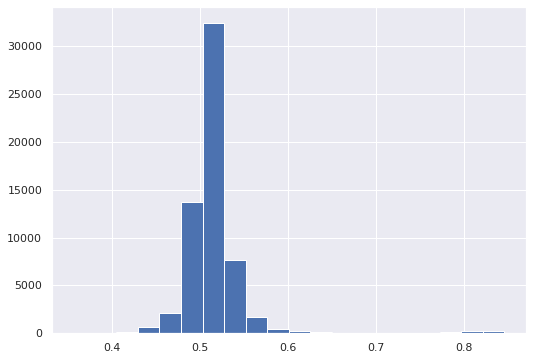

In [ ]:
plt.hist(final_pred, bins=20);

In [ ]:
df_submission = pd.DataFrame({'client_id': df_test.client_id, 'pred': final_pred})
df_submission

,client_id,pred
0,00010925a5,0.511012
1,00035a21d9,0.534668
2,00038f9200,0.534087
3,0004315e57,0.497860
4,0006fca4bf,0.520207
...,...,...
60007,fff9aa288c,0.535009
60008,fff9f772f6,0.778102
60009,fffe0ed719,0.518346
60010,fffea1204c,0.521469


In [ ]:
df_submission.to_csv('submission.csv', index=False)